In [ ]:
# 🔥 Úplné odstránenie nekompatibilných verzií
!pip uninstall -y transformers huggingface-hub tokenizers sentence-transformers peft

# 🧹 (ak máš oprávnenie) Vyčistenie cache
!rm -rf /root/.cache/huggingface

# ✅ Inštalácia stabilných verzií, ktoré sú 100 % kompatibilné s Trainer
!pip install transformers==4.40.1 huggingface-hub==0.30.2 tokenizers==0.19.1

2. Načítanie a stratifikovaný výber 20k komentárov

In [15]:

from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = load_dataset("civil_comments", split="train")
df = dataset.to_pandas()
df["toxicity_label"] = (df["toxicity"] >= 0.5).astype(int)

# Stratifikovaný výber 20 000 komentárov
df_sample, _ = train_test_split(df, train_size=20000, stratify=df["toxicity_label"], random_state=42)

# Stratifikované rozdelenie na train/val/test
train_df, temp_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample["toxicity_label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["toxicity_label"], random_state=42)

# Výpis distribúcie
for name, split in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"📊 {name} množina: {len(split)} komentárov")
    print(split["toxicity_label"].value_counts(normalize=True).rename("proportion"))
    print(split["toxicity_label"].value_counts().rename("počet"), "\n")

train_df.to_csv("train_civil.csv", index=False)
val_df.to_csv("val_civil.csv", index=False)
test_df.to_csv("test_civil.csv", index=False)


📊 Train množina: 16000 komentárov
toxicity_label
0    0.920063
1    0.079937
Name: proportion, dtype: float64
toxicity_label
0    14721
1     1279
Name: počet, dtype: int64 

📊 Val množina: 2000 komentárov
toxicity_label
0    0.92
1    0.08
Name: proportion, dtype: float64
toxicity_label
0    1840
1     160
Name: počet, dtype: int64 

📊 Test množina: 2000 komentárov
toxicity_label
0    0.92
1    0.08
Name: proportion, dtype: float64
toxicity_label
0    1840
1     160
Name: počet, dtype: int64 



# ToxicBERT – Binárna klasifikácia (toxický vs netoxický)

Tento notebook replikujestruktúru SlovakBERT modelu, aplikovanú na anglický dataset `civil_comments`.

In [16]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

Using device: cuda


In [17]:
from datasets import Dataset
from transformers import AutoTokenizer

# ✅ Najprv vytvorenie Hugging Face Dataset objektov
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

# ✅ Inicializácia tokenizer-a
checkpoint = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# ✅ Tokenizačná funkcia
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

# ✅ Tokenizácia
train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

# ✅ Premenovanie stĺpca "toxicity_label" na "label" (potrebné pre Trainer)
train_ds = train_ds.rename_column("toxicity_label", "label")
val_ds = val_ds.rename_column("toxicity_label", "label")
test_ds = test_ds.rename_column("toxicity_label", "label")

# ✅ Nastavenie formátu pre PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
!pip install evaluate

from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
import numpy as np

# Nastavenie checkpointu
checkpoint = "unitary/toxic-bert"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Správna konfigurácia pre binárnu klasifikáciu
config = AutoConfig.from_pretrained(checkpoint)
config.num_labels = 2
config.problem_type = "single_label_classification"

# Model s upravenou konfiguráciou a automatickou zmenou výstupnej vrstvy
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    config=config,
    ignore_mismatched_sizes=True
).to(device)

# Metriky
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

# Tréningové argumenty – upravené proti overfittingu
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,  # znížené z 10 → 5
    learning_rate=1e-5,  # znížené z 2e-5 → 1e-5
    weight_decay=0.01,
    label_smoothing_factor=0.1,  # 🔧 pridané
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)


# Tréner s early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,     # Uisti sa, že train_ds je pripravený
    eval_dataset=val_ds,        # Uisti sa, že val_ds je pripravený
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Tréning
train_result = trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at unitary/toxic-bert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.299400,0.284686,0.955000,0.832698
2,0.268700,0.293405,0.948000,0.823370
3,0.244100,0.313322,0.943000,0.814800


Matthews Correlation Coefficient (MCC): 0.5409


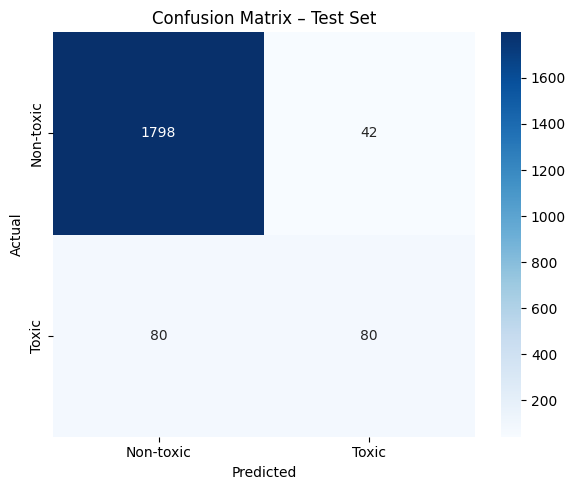

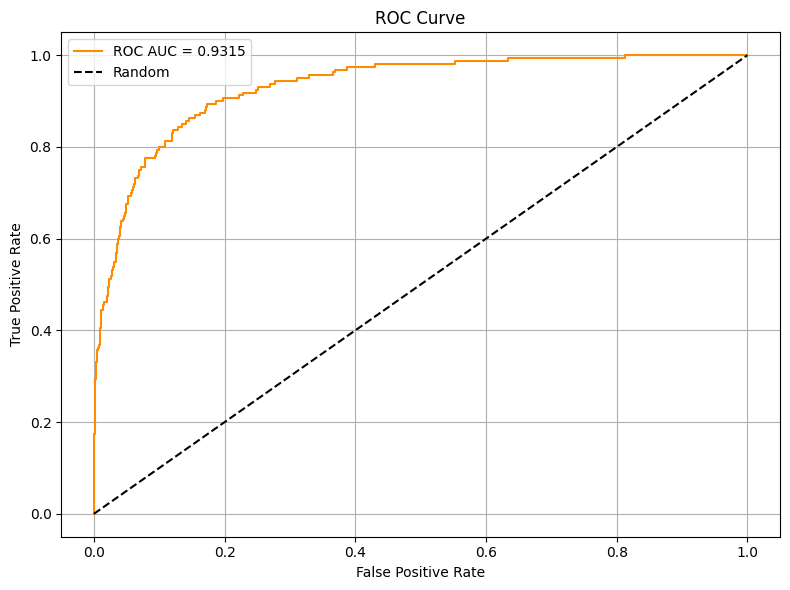

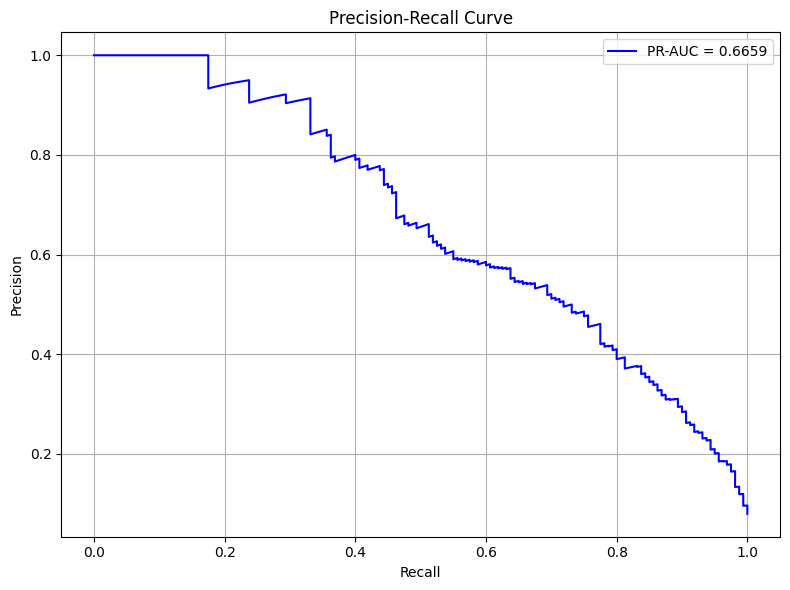

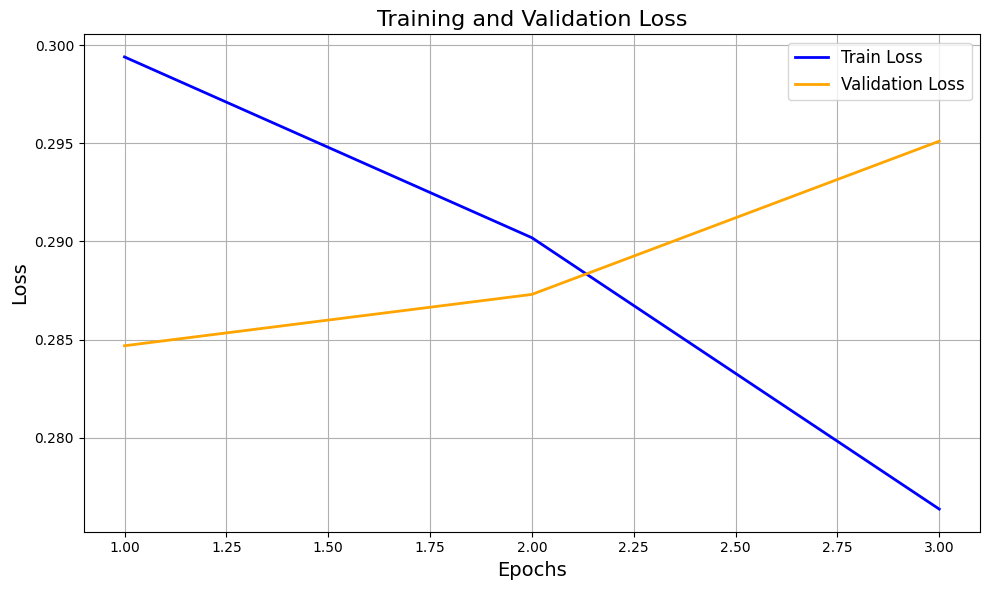

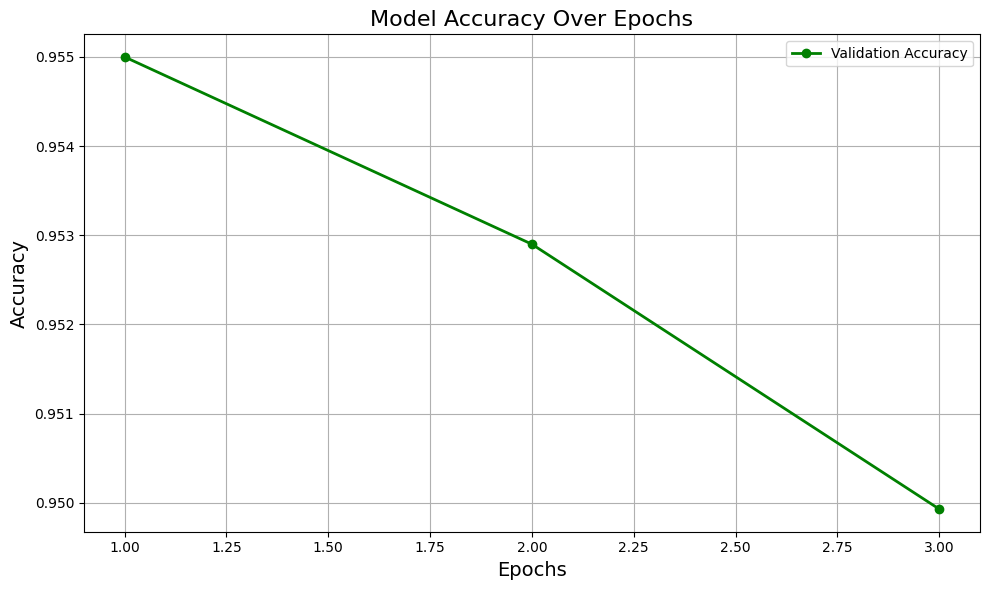

Text: Dont forget to blame trump. Hes a hater doncha know!!...
Predicted: 0, Actual: 1, Confidence: 0.4951
--------------------------------------------------------------------------------
Text: Yes, the U.S. definitely has a clown problem......
Predicted: 0, Actual: 1, Confidence: 0.4950
--------------------------------------------------------------------------------
Text: Where is this bucket list from this monolithic "alt right" that lists the agenda to "destroy the sys...
Predicted: 1, Actual: 0, Confidence: 0.5106
--------------------------------------------------------------------------------
Text: Here is what the burka really is. It is a middle finger directed at Western secular societies. It is...
Predicted: 1, Actual: 0, Confidence: 0.5138
--------------------------------------------------------------------------------
Text: Well Roy, you don't fix anything just stir hatred and foolishness and never have. If you are so grea...
Predicted: 1, Actual: 0, Confidence: 0.5366
------

In [19]:

# ✅ ZLEPŠENÉ VYHODNOTENIE – ROC AUC, MCC, hladšie grafy, chybová analýza

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, matthews_corrcoef, auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import os

output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

# Predikcie na testovacej množine
preds_output = trainer.predict(test_ds)
labels = preds_output.label_ids
final_preds = np.argmax(preds_output.predictions, axis=1)
probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1].numpy()

# 📄 Classification Report
report = classification_report(labels, final_preds, target_names=["Non-toxic", "Toxic"], digits=4, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{output_dir}/classification_report_full.csv")

with open(f"{output_dir}/classification_report.txt", "w") as f:
    f.write(classification_report(labels, final_preds, target_names=["Non-toxic", "Toxic"], digits=4))

# 📌 Matthews Correlation Coefficient
mcc = matthews_corrcoef(labels, final_preds)
print("Matthews Correlation Coefficient (MCC):", round(mcc, 4))

# 📊 Confusion Matrix
cm = confusion_matrix(labels, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-toxic", "Toxic"],
            yticklabels=["Non-toxic", "Toxic"])
plt.title("Confusion Matrix – Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png", dpi=300)
plt.show()

# 📈 ROC Curve
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = roc_auc_score(labels, probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curve.png", dpi=300)
plt.show()

# 📈 Precision-Recall Curve
precision, recall, _ = precision_recall_curve(labels, probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/precision_recall_curve.png", dpi=300)
plt.show()

# 📉 Zlepšené grafy – len po epochách
epoch_logs = [x for x in trainer.state.log_history if "epoch" in x and "eval_loss" in x]

def smooth(values, alpha=0.3):
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = alpha * v + (1 - alpha) * last
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

train_loss_epoch = [x["loss"] for x in trainer.state.log_history if "loss" in x and "epoch" in x]
val_loss_epoch = [x["eval_loss"] for x in epoch_logs]
acc_epoch = [x["eval_accuracy"] for x in epoch_logs]
epochs = [x["epoch"] for x in epoch_logs]

# Loss graf
plt.figure(figsize=(10, 6))
plt.plot(epochs, smooth(train_loss_epoch), label="Train Loss", color="blue", linewidth=2)
plt.plot(epochs, smooth(val_loss_epoch), label="Validation Loss", color="orange", linewidth=2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training and Validation Loss", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/loss_clean_graph.png", dpi=300)
plt.show()

# Accuracy graf
plt.figure(figsize=(10, 6))
plt.plot(epochs, smooth(acc_epoch), label="Validation Accuracy", marker='o', color="green", linewidth=2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Model Accuracy Over Epochs", fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/accuracy_graph.png", dpi=300)
plt.show()

# 🧪 Chybová analýza – najneistejšie nesprávne predikcie
try:
    test_texts = test_ds["text"]
    errors = [(i, p, l, prob) for i, (p, l, prob) in enumerate(zip(final_preds, labels, probs)) if p != l]
    errors_sorted = sorted(errors, key=lambda x: abs(x[3] - 0.5))[:5]

    for idx, pred, label, prob in errors_sorted:
        print(f"Text: {test_texts[idx][:100]}...")
        print(f"Predicted: {pred}, Actual: {label}, Confidence: {prob:.4f}")
        print("-" * 80)
except:
    print("Chybová analýza: Texty nie sú dostupné.")

In [14]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Výpočet mikro, makro a weighted metrík
f1_micro = f1_score(labels, final_preds, average='micro')
f1_macro = f1_score(labels, final_preds, average='macro')
f1_weighted = f1_score(labels, final_preds, average='weighted')

precision_micro = precision_score(labels, final_preds, average='micro')
precision_macro = precision_score(labels, final_preds, average='macro')
precision_weighted = precision_score(labels, final_preds, average='weighted')

recall_micro = recall_score(labels, final_preds, average='micro')
recall_macro = recall_score(labels, final_preds, average='macro')
recall_weighted = recall_score(labels, final_preds, average='weighted')

print(f"F1 micro: {f1_micro:.4f}")
print(f"F1 macro: {f1_macro:.4f}")
print(f"F1 weighted: {f1_weighted:.4f}")
print(f"Precision micro: {precision_micro:.4f}")
print(f"Precision macro: {precision_macro:.4f}")
print(f"Precision weighted: {precision_weighted:.4f}")
print(f"Recall micro: {recall_micro:.4f}")
print(f"Recall macro: {recall_macro:.4f}")
print(f"Recall weighted: {recall_weighted:.4f}")

# Uloženie do CSV pre bakalársku prácu
import pandas as pd
metrics_summary = pd.DataFrame({
    "F1": [f1_micro, f1_macro, f1_weighted],
    "Precision": [precision_micro, precision_macro, precision_weighted],
    "Recall": [recall_micro, recall_macro, recall_weighted]
}, index=["micro", "macro", "weighted"])

metrics_summary.to_csv(f"{output_dir}/micro_macro_metrics.csv", float_format="%.4f")
metrics_summary

F1 micro: 0.9390
F1 macro: 0.7673
F1 weighted: 0.9352
Precision micro: 0.9390
Precision macro: 0.8066
Precision weighted: 0.9333
Recall micro: 0.9390
Recall macro: 0.7386
Recall weighted: 0.9390


,F1,Precision,Recall
micro,0.939000,0.939000,0.939000
macro,0.767281,0.806570,0.738587
weighted,0.935202,0.933268,0.939000


In [20]:
import zipfile
import os

output_zip = "toxicbert_bin_results.zip"
results_dir = "results"

with zipfile.ZipFile(output_zip, "w") as zipf:
    for file in os.listdir(results_dir):
        if file.endswith(".png") or file.endswith(".csv") or file.endswith(".txt"):
            zipf.write(os.path.join(results_dir, file), arcname=file)

print(f"ZIP súbor vytvorený: {output_zip}")


ZIP súbor vytvorený: toxicbert_bin_results.zip
